<a href="https://colab.research.google.com/github/yiboxu20/MachineLearning/blob/main/Resources/Module1/KNN2_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is from https://github.com/johny-c/pylmnn

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#@title uility function
import numpy as np
from sklearn.utils.extmath import row_norms, safe_sparse_dot


def _euclidean_distances_without_checks(X, Y=None, Y_norm_squared=None,
                                        squared=False, X_norm_squared=None,
                                        clip=True):
    """sklearn.pairwise.euclidean_distances without checks with optional clip.
    Parameters
    ----------
    X : {array-like, sparse matrix}, shape (n_samples_1, n_features)
    Y : {array-like, sparse matrix}, shape (n_samples_2, n_features)
    Y_norm_squared : array-like, shape (n_samples_2, ), optional
        Pre-computed dot-products of vectors in Y (e.g.,
        ``(Y**2).sum(axis=1)``)
    squared : boolean, optional
        Return squared Euclidean distances.
    X_norm_squared : array-like, shape = [n_samples_1], optional
        Pre-computed dot-products of vectors in X (e.g.,
        ``(X**2).sum(axis=1)``)
    clip : bool, optional (default=True)
        Whether to explicitly enforce computed distances to be non-negative.
        Some algorithms, such as LargeMarginNearestNeighbor, compare distances
        to strictly positive values (distances to farthest target neighbors
        + margin) only to make a binary decision (if a sample is an impostor
        or not). In such cases, it does not matter if the distance is zero
        or negative, since it is definitely smaller than a strictly positive
        value.
    Returns
    -------
    distances : array, shape (n_samples_1, n_samples_2)
    """

    if Y is None:
        Y = X

    if X_norm_squared is not None:
        XX = X_norm_squared
        if XX.shape == (1, X.shape[0]):
            XX = XX.T
    else:
        XX = row_norms(X, squared=True)[:, np.newaxis]

    if X is Y:  # shortcut in the common case euclidean_distances(X, X)
        YY = XX.T
    elif Y_norm_squared is not None:
        YY = np.atleast_2d(Y_norm_squared)
    else:
        YY = row_norms(Y, squared=True)[np.newaxis, :]

    distances = safe_sparse_dot(X, Y.T, dense_output=True)
    distances *= -2
    distances += XX
    distances += YY

    if clip:
        np.maximum(distances, 0, out=distances)

    if X is Y:
        # Ensure that distances between vectors and themselves are set to 0.0.
        # This may not be the case due to floating point rounding errors.
        distances.flat[::distances.shape[0] + 1] = 0.0

    return distances if squared else np.sqrt(distances, out=distances)




def plot_comparison(components, X, y, dim_pref=2, t_sne=False):
    """Draw a scatter plot of points, colored by their labels, before and after applying a learned transformation
    Parameters
    ----------
    components : array_like
        The learned transformation in an array with shape (n_components, n_features).
    X : array_like
        An array of data samples with shape (n_samples, n_features).
    y : array_like
        An array of data labels with shape (n_samples,).
    dim_pref : int
        The preferred number of dimensions to plot (default: 2).
    t_sne : bool
        Whether to use t-SNE to produce the plot or just use the first two dimensions
        of the inputs (default: False).
    """
    if dim_pref < 2 or dim_pref > 3:
        print('Preferred plot dimensionality must be 2 or 3, setting to 2!')
        dim_pref = 2

    if t_sne:
        print("Computing t-SNE embedding")
        tsne = TSNE(n_components=dim_pref, init='pca', random_state=0)
        X_tsne = tsne.fit_transform(X)
        Lx_tsne = tsne.fit_transform(X.dot(components.T))
        X = X_tsne
        Lx = Lx_tsne
    else:
        Lx = X.dot(components.T)

    fig = plt.figure()
    if X.shape[1] > 2 and dim_pref == 3:
        ax = fig.add_subplot(121, projection='3d')
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
        ax.set_title('Original Data')
        ax = fig.add_subplot(122, projection='3d')
        ax.scatter(Lx[:, 0], Lx[:, 1], Lx[:, 2], c=y)
        ax.set_title('Transformed Data')
    elif X.shape[1] >= 2:
        ax = fig.add_subplot(121)
        ax.scatter(X[:, 0], X[:, 1], c=y)
        ax.set_title('Original Data')
        ax = fig.add_subplot(122)
        ax.scatter(Lx[:, 0], Lx[:, 1], c=y)
        ax.set_title('Transformed Data')


In [ ]:
#@title Large Margin Nearest Neighbor implementation
# coding: utf-8
"""
Large Margin Nearest Neighbor Classification
"""

# Author: John Chiotellis <johnyc.code@gmail.com>
# License: BSD 3 clause

from __future__ import print_function
from warnings import warn

import sys
import time
import numpy as np
import builtins
from scipy.optimize import minimize
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.utils import gen_batches
from sklearn.utils.extmath import row_norms, safe_sparse_dot
from sklearn.utils.random import check_random_state
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import check_is_fitted, check_array, check_X_y
from sklearn.exceptions import ConvergenceWarning
try:
    from six import integer_types, string_types
except ImportError:
    try:
        from sklearn.externals.six import integer_types, string_types
    except ImportError:
        raise ImportError("The module six must be installed or the version of scikit-learn version must be < 0.23")


class LargeMarginNearestNeighbor(BaseEstimator, TransformerMixin):
    """Distance metric learning for large margin classification.
    Parameters
    ----------
    n_neighbors : int, optional (default=3)
        Number of neighbors to use as target neighbors for each sample.
    n_components : int, optional (default=None)
        Preferred dimensionality of the embedding.
        If None it is inferred from ``init``.
    init : string or numpy array, optional (default='pca')
        Initialization of the linear transformation. Possible options are
        'pca', 'identity' and a numpy array of shape (n_features_a,
        n_features_b).
        pca:
            ``n_components`` many principal components of the inputs passed
            to :meth:`fit` will be used to initialize the transformation.
        identity:
            If ``n_components`` is strictly smaller than the
            dimensionality of the inputs passed to :meth:`fit`, the identity
            matrix will be truncated to the first ``n_components`` rows.
        numpy array:
            n_features_b must match the dimensionality of the inputs passed to
            :meth:`fit` and n_features_a must be less than or equal to that.
            If ``n_components`` is not None, n_features_a must match it.
    warm_start : bool, optional, (default=False)
        If True and :meth:`fit` has been called before, the solution of the
        previous call to :meth:`fit` is used as the initial linear
        transformation (``n_components`` and ``init`` will be ignored).
    max_impostors : int, optional (default=500000)
        Maximum number of impostors to consider per iteration. In the worst
        case this will allow ``max_impostors * n_neighbors`` constraints to be
        active.
    neighbors_params : dict, optional (default=None)
        Parameters to pass to a :class:`neighbors.NearestNeighbors` instance -
        apart from ``n_neighbors`` - that will be used to select the target
        neighbors.
    weight_push_loss : float, optional (default=0.5)
        A float in (0, 1], weighting the push loss. This is parameter ``μ``
        in the journal paper (See references below). In practice, the objective
        function will be normalized so that the push loss has weight 1 and
        hence the pull loss has weight ``(1 - μ)/μ``.
    impostor_store : str ['auto'|'list'|'sparse'], optional
        list :
            Three lists will be used to store the indices of reference
            samples, the indices of their impostors and the (squared)
            distances between the (sample, impostor) pairs.
        sparse :
            A sparse indicator matrix will be used to store the (sample,
            impostor) pairs. The (squared) distances to the impostors will be
            computed twice (once to determine the impostors and once to be
            stored), but this option tends to be faster than 'list' as the
            size of the data set increases.
        auto :
            Will attempt to decide the most appropriate choice of data
            structure based on the values passed to :meth:`fit`.
    max_iter : int, optional (default=50)
        Maximum number of iterations in the optimization.
    tol : float, optional (default=1e-5)
        Convergence tolerance for the optimization.
    callback : callable, optional (default=None)
        If not None, this function is called after every iteration of the
        optimizer, taking as arguments the current solution (transformation)
        and the number of iterations. This might be useful in case one wants
        to examine or store the transformation found after each iteration.
    store_opt_result : bool, optional (default=False)
        If True, the :class:`scipy.optimize.OptimizeResult` object returned by
        :meth:`minimize` of `scipy.optimize` will be stored as attribute
        ``opt_result_``.
    verbose : int, optional (default=0)
        If 0, no progress messages will be printed.
        If 1, progress messages will be printed to stdout.
        If > 1, progress messages will be printed and the ``iprint``
        parameter of :meth:`_minimize_lbfgsb` of `scipy.optimize` will be set
        to ``verbose - 2``.
    random_state : int or numpy.RandomState or None, optional (default=None)
        A pseudo random number generator object or a seed for it if int.
    n_jobs : int, optional (default=1)
        The number of parallel jobs to run for neighbors search.
        If ``-1``, then the number of jobs is set to the number of CPU cores.
        Doesn't affect :meth:`fit` method.
    Attributes
    ----------
    components_ : array, shape (n_components, n_features)
        The linear transformation learned during fitting.
    n_neighbors_ : int
        The provided ``n_neighbors`` is decreased if it is greater than or
        equal to  min(number of elements in each class).
    n_iter_ : int
        Counts the number of iterations performed by the optimizer.
    opt_result_ : scipy.optimize.OptimizeResult (optional)
        A dictionary of information representing the optimization result.
        This is stored only if ``store_opt_result`` is True. It contains the
        following attributes:
        x : ndarray
            The solution of the optimization.
        success : bool
            Whether or not the optimizer exited successfully.
        status : int
            Termination status of the optimizer.
        message : str
            Description of the cause of the termination.
        fun, jac : ndarray
            Values of objective function and its Jacobian.
        hess_inv : scipy.sparse.linalg.LinearOperator
            the product of a vector with the approximate inverse of the
            Hessian of the objective function..
        nfev : int
            Number of evaluations of the objective function..
        nit : int
            Number of iterations performed by the optimizer.
    Examples
    --------
    >>> from pylmnn import LargeMarginNearestNeighbor
    >>> from sklearn.neighbors import KNeighborsClassifier
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import train_test_split
    >>> X, y = load_iris(return_X_y=True)
    >>> X_train, X_test, y_train, y_test = train_test_split(X, y,
    ... stratify=y, test_size=0.7, random_state=42)
    >>> lmnn = LargeMarginNearestNeighbor(n_neighbors=3, random_state=42)
    >>> lmnn.fit(X_train, y_train) # doctest: +ELLIPSIS
    LargeMarginNearestNeighbor(...)
    >>> # Fit and evaluate a simple nearest neighbor classifier for comparison
    >>> knn = KNeighborsClassifier(n_neighbors=3)
    >>> knn.fit(X_train, y_train) # doctest: +ELLIPSIS
    KNeighborsClassifier(...)
    >>> print(knn.score(X_test, y_test))
    0.933333333333
    >>> # Now fit on the data transformed by the learned transformation
    >>> knn.fit(lmnn.transform(X_train), y_train) # doctest: +ELLIPSIS
    KNeighborsClassifier(...)
    >>> print(knn.score(lmnn.transform(X_test), y_test))
    0.971428571429
    .. warning::
        Exact floating-point reproducibility is generally not guaranteed
        (unless special care is taken with library and compiler options). As
        a consequence, the transformations computed in 2 identical runs of
        LargeMarginNearestNeighbor can differ from each other. This can
        happen even before the optimizer is called if initialization with
        PCA is used (init='pca').
    References
    ----------
    .. [1] Weinberger, Kilian Q., and Lawrence K. Saul.
           "Distance Metric Learning for Large Margin Nearest Neighbor
           Classification."
           Journal of Machine Learning Research, Vol. 10, Feb. 2009,
           pp. 207-244.
           http://jmlr.csail.mit.edu/papers/volume10/weinberger09a/weinberger09a.pdf
    .. [2] Wikipedia entry on Large Margin Nearest Neighbor
           https://en.wikipedia.org/wiki/Large_margin_nearest_neighbor
    """

    def __init__(self, n_neighbors=3, n_components=None, init='pca',
                 warm_start=False, max_impostors=500000, neighbors_params=None,
                 weight_push_loss=0.5, impostor_store='auto', max_iter=50,
                 tol=1e-5, callback=None, store_opt_result=False, verbose=0,
                 random_state=None, n_jobs=1):

        # Parameters
        self.n_neighbors = n_neighbors
        self.n_components = n_components
        self.init = init
        self.warm_start = np.bool_(warm_start)
        self.max_impostors = max_impostors
        self.neighbors_params = neighbors_params
        self.weight_push_loss = weight_push_loss
        self.impostor_store = impostor_store
        self.max_iter = max_iter
        self.tol = tol
        self.callback = callback
        self.store_opt_result = store_opt_result
        self.verbose = verbose
        self.random_state = random_state
        self.n_jobs = n_jobs

    def fit(self, X, y):
        """Fit the model according to the given training data.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training samples.
        y : array-like, shape (n_samples,)
            The corresponding training labels.
        Returns
        -------
        self : object
            returns a trained LargeMarginNearestNeighbor model.
        """

        # Validate the inputs
        X, y = check_X_y(X, y, ensure_min_samples=2)
        check_classification_targets(y)

        # Check that the inputs are consistent with the parameters
        X_valid, y_valid, classes, init = self._validate_params(X, y)

        # Initialize the random generator
        self.random_state_ = check_random_state(self.random_state)

        # Measure the total training time
        t_train = time.time()

        # Initialize the linear transformation
        transformation = self._initialize(X_valid, init)

        # Find the target neighbors
        target_neighbors = self._select_target_neighbors_wrapper(
            X_valid, y_valid, classes)

        # Compute the gradient part contributed by the target neighbors
        grad_static = self._compute_grad_static(X_valid, target_neighbors)

        # Compute the pull loss coefficient
        pull_loss_coef = (1. - self.weight_push_loss) / self.weight_push_loss
        grad_static *= pull_loss_coef

        # Decide how to store the impostors
        if self.impostor_store == 'sparse':
            use_sparse = True
        elif self.impostor_store == 'list':
            use_sparse = False
        else:
            # auto: Use a heuristic based on the data set size
            use_sparse = X_valid.shape[0] > 6500

        # Create a dictionary of parameters to be passed to the optimizer
        disp = self.verbose - 2 if self.verbose > 1 else -1
        optimizer_params = {'method': 'L-BFGS-B',
                            'fun': self._loss_grad_lbfgs,
                            'jac': True,
                            'args': (X_valid, y_valid, classes,
                                     target_neighbors, grad_static,
                                     use_sparse),
                            'x0': transformation.ravel(),
                            'tol': self.tol,
                            'options': dict(maxiter=self.max_iter),  # Remove disp parameter
                            # 'options': dict(maxiter=self.max_iter, disp=disp),
                            'callback': self._callback
                            }

        # Call the optimizer
        self.n_iter_ = 0
        opt_result = minimize(**optimizer_params)

        # Reshape the solution found by the optimizer
        self.components_ = opt_result.x.reshape(-1, X_valid.shape[1])

        # Stop timer
        t_train = time.time() - t_train
        if self.verbose:
            cls_name = self.__class__.__name__

            # Warn the user if the algorithm did not converge
            if not opt_result.success:
                warn('[{}] LMNN did not converge: {}'.format(
                    cls_name, opt_result.message),
                     ConvergenceWarning)

            print('[{}] Training took {:8.2f}s.'.format(cls_name, t_train))

        # Optionally store information returned by the optimizer
        if self.store_opt_result:
            self.opt_result_ = opt_result

        return self

    def transform(self, X):
        """Applies the learned transformation to the given data.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Data samples.
        Returns
        -------
        X_embedded: array, shape (n_samples, n_components)
            The data samples transformed.
        Raises
        ------
        NotFittedError
            If :meth:`fit` has not been called before.
        """

        check_is_fitted(self, ['components_'])
        X = check_array(X)

        return np.dot(X, self.components_.T)

    def _transform_without_checks(self, X):
        """Same as transform but without validating the inputs.
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
            Data samples.
        Returns
        -------
        X_embedded: array, shape (n_samples, n_components)
            The data samples transformed.
        """
        return np.dot(X, self.components_.T)

    def _validate_params(self, X, y):
        """Validate parameters as soon as :meth:`fit` is called.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training samples.
        y : array-like, shape (n_samples,)
            The corresponding training labels.
        Returns
        -------
        X : array, shape (n_samples, n_features)
            The validated training samples.
        y_inverse : array, shape (n_samples,)
            The validated training labels, encoded to be integers in
            the range(0, n_classes).
        classes_inverse_non_singleton : array, shape (n_classes_non_singleton,)
            The non-singleton classes, encoded as integers in [0, n_classes).
        init : string or numpy array of shape (n_features_a, n_features_b)
            The validated initialization of the linear transformation.
        Raises
        -------
        TypeError
            If a parameter is not an instance of the desired type.
        ValueError
            If a parameter's value violates its legal value range or if the
            combination of two or more given parameters is incompatible.
        """

        # Find the appearing classes and the class index for each sample
        classes, y_inverse = np.unique(y, return_inverse=True)
        classes_inverse = np.arange(len(classes))

        # Ignore classes that have less than 2 samples (singleton classes)
        class_sizes = np.bincount(y_inverse)
        if class_sizes.ndim == 0:
            class_sizes = np.array([class_sizes])
        mask_singleton_class = class_sizes == 1
        singleton_classes = np.where(mask_singleton_class)[0]
        if len(singleton_classes):
            warn('There are {} singleton classes that will be ignored during '
                 'training. A copy of the inputs `X` and `y` will be made.'
                 .format(len(singleton_classes)))
            mask_singleton_sample = np.asarray([yi in singleton_classes for
                                                yi in y_inverse])
            X = X[~mask_singleton_sample].copy()
            y_inverse = y_inverse[~mask_singleton_sample].copy()

        # Check that there are at least 2 non-singleton classes
        n_classes_non_singleton = len(classes) - len(singleton_classes)
        if n_classes_non_singleton < 2:
            raise ValueError('LargeMarginNearestNeighbor needs at least 2 '
                             'non-singleton classes, got {}.'
                             .format(n_classes_non_singleton))

        classes_inverse_non_singleton = classes_inverse[~mask_singleton_class]

        # Check the preferred embedding dimensionality
        if self.n_components is not None:
            _check_scalar(self.n_components, 'n_components',
                          integer_types, 1)

            if self.n_components > X.shape[1]:
                raise ValueError('The preferred embedding dimensionality '
                                 '`n_components` ({}) cannot be greater '
                                 'than the given data dimensionality ({})!'
                                 .format(self.n_components, X.shape[1]))

        # If warm_start is enabled, check that the inputs are consistent
        _check_scalar(self.warm_start, 'warm_start', bool)
        if self.warm_start and hasattr(self, 'components_'):
            if self.components_.shape[1] != X.shape[1]:
                raise ValueError('The new inputs dimensionality ({}) does not '
                                 'match the input dimensionality of the '
                                 'previously learned transformation ({}).'
                                 .format(X.shape[1],
                                         self.components_.shape[1]))

        _check_scalar(self.n_neighbors, 'n_neighbors', integer_types, 1,
                      X.shape[0] - 1)
        _check_scalar(self.max_iter, 'max_iter', integer_types, 1)
        _check_scalar(self.tol, 'tol', float, 0.)
        _check_scalar(self.weight_push_loss, 'weight_push_loss', float, 0., 1.)
        if self.weight_push_loss == 0:
            raise ValueError('`weight_push_loss` cannot be zero.')

        _check_scalar(self.max_impostors, 'max_impostors', integer_types, 1)
        _check_scalar(self.impostor_store, 'impostor_store', string_types)
        _check_scalar(self.n_jobs, 'n_jobs', integer_types)
        _check_scalar(self.verbose, 'verbose', integer_types, 0)

        if self.impostor_store not in ['auto', 'sparse', 'list']:
            raise ValueError("`impostor_store` must be 'auto', 'sparse' or "
                             "'list'.")

        if self.callback is not None:
            if not callable(self.callback):
                raise ValueError('`callback` is not callable.')

        # Check how the linear transformation should be initialized
        init = self.init
        if isinstance(init, np.ndarray):
            init = check_array(init)

            # Assert that init.shape[1] = X.shape[1]
            if init.shape[1] != X.shape[1]:
                raise ValueError('The input dimensionality ({}) of the given '
                                 'linear transformation `init` must match the '
                                 'dimensionality of the given inputs `X` ({}).'
                                 .format(init.shape[1], X.shape[1]))

            # Assert that init.shape[0] <= init.shape[1]
            if init.shape[0] > init.shape[1]:
                raise ValueError('The output dimensionality ({}) of the given '
                                 'linear transformation `init` cannot be '
                                 'greater than its input dimensionality ({}).'
                                 .format(init.shape[0], init.shape[1]))

            if self.n_components is not None:
                # Assert that self.n_components = init.shape[0]
                if self.n_components != init.shape[0]:
                    raise ValueError('The preferred embedding dimensionality '
                                     '`n_components` ({}) does not match '
                                     'the output dimensionality of the given '
                                     'linear transformation `init` ({})!'
                                     .format(self.n_components,
                                             init.shape[0]))
        elif init in ['pca', 'identity']:
            pass
        else:
            raise ValueError("`init` must be 'pca', 'identity', or a numpy "
                             "array of shape (n_components, n_features).")

        # Check the preferred number of neighbors
        non_singleton_sizes = class_sizes[~mask_singleton_class]
        # Handle case where there might be no non-singleton classes
        if non_singleton_sizes.size > 0:
            min_non_singleton_size = non_singleton_sizes.min().item()
        else:
            min_non_singleton_size = 2
        if self.n_neighbors >= min_non_singleton_size:
            warn('`n_neighbors` (={}) is not less than the number of '
                 'samples in the smallest non-singleton class (={}). '
                 '`n_neighbors_` will be set to {} for estimation.'
                 .format(self.n_neighbors, min_non_singleton_size,
                         min_non_singleton_size - 1))

        min_non_singleton_python = int(min_non_singleton_size)
        self.n_neighbors_ = builtins.min(int(self.n_neighbors), builtins.max(1, min_non_singleton_size - 1)) # min max are over-written
        # min_non_singleton_py = int(min_non_singleton_size)
        # n_neighbors_py = int(self.n_neighbors)

        # if n_neighbors_py < min_non_singleton_py - 1:
        #     self.n_neighbors_ = n_neighbors_py
        # else:
        #     self.n_neighbors_ = min_non_singleton_py - 1


        neighbors_params = self.neighbors_params
        if neighbors_params is not None:
            _check_scalar(neighbors_params, 'neighbors_params', dict)
            neighbors_params.setdefault('n_jobs', self.n_jobs)
            # Attempt to instantiate a NearestNeighbors instance here to
            # raise any errors before actually fitting
            NearestNeighbors(n_neighbors=self.n_neighbors_, **neighbors_params)

        return X, y_inverse, classes_inverse_non_singleton, init

    def _initialize(self, X, init):
        """
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
            The training samples.
        init : string or numpy array of shape (n_features_a, n_features)
            The initialization of the linear transformation.
        Returns
        -------
        transformation : array, shape (n_components, n_features)
            The initialized linear transformation.
        """

        transformation = init
        if self.warm_start and hasattr(self, 'components_'):
            transformation = self.components_

        elif isinstance(init, np.ndarray):
            pass

        elif init == 'pca':
            pca = PCA(n_components=self.n_components,
                      random_state=self.random_state_)
            t_pca = time.time()
            if self.verbose:
                print('[{}] Finding principal components...'.format(
                    self.__class__.__name__))
                sys.stdout.flush()

            pca.fit(X)
            if self.verbose:
                t_pca = time.time() - t_pca
                print('[{}] Found principal components in {:5.2f}s.'.format(
                    self.__class__.__name__, t_pca))

            transformation = pca.components_

        elif init == 'identity':
            if self.n_components is None:
                transformation = np.eye(X.shape[1])
            else:
                transformation = np.eye(self.n_components, X.shape[1])

        return transformation

    def _select_target_neighbors_wrapper(self, X, y, classes=None):
        """Find the target neighbors of each data sample.
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
            The training samples.
        y : array, shape (n_samples,)
            The corresponding training labels indices.
        classes : array, shape (n_classes,), optional (default=None)
            The non-singleton classes, encoded as integers in [0, n_classes).
            If None (default), they will be inferred from ``y``.
        Returns
        -------
        target_neighbors: array, shape (n_samples, n_neighbors)
            An array of neighbors indices for each sample.
        """

        t_start = time.time()
        if self.verbose:
            print('[{}] Finding the target neighbors...'.format(
                self.__class__.__name__))
            sys.stdout.flush()

        neighbors_params = self.neighbors_params
        if neighbors_params is None:
            neighbors_params = {}

        neighbors_params.setdefault('n_jobs', self.n_jobs)
        target_neighbors = _select_target_neighbors(
            X, y, self.n_neighbors_, classes=classes, **neighbors_params)

        if self.verbose:
            print('[{}] Found the target neighbors in {:5.2f}s.'.format(
                self.__class__.__name__, time.time() - t_start))

        return target_neighbors

    def _compute_grad_static(self, X, target_neighbors):
        """Compute the gradient contributed by the target neighbors.
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
            The training samples.
        target_neighbors : array, shape (n_samples, n_neighbors)
            The k nearest neighbors of each sample from the same class.
        Returns
        -------
        grad_target_neighbors, shape (n_features, n_features)
            An array with the sum of all outer products of
            (sample, target_neighbor) pairs.
        """

        t_grad_static = time.time()
        if self.verbose:
            print('[{}] Computing static part of the gradient...'.format(
                self.__class__.__name__))

        n_samples, n_neighbors = target_neighbors.shape
        row = np.repeat(range(n_samples), n_neighbors)
        col = target_neighbors.ravel()
        tn_graph = csr_matrix((np.ones(target_neighbors.size), (row, col)),
                              shape=(n_samples, n_samples))
        grad_target_neighbors = _sum_weighted_outer_differences(X, tn_graph)

        if self.verbose:
            t_grad_static = time.time() - t_grad_static
            print('[{}] Computed static part of the gradient in {:5.2f}s.'
                  .format(self.__class__.__name__, t_grad_static))

        return grad_target_neighbors

    def _callback(self, transformation):
        """Called after each iteration of the optimizer.
        Parameters
        ----------
        transformation : array, shape(n_components, n_features)
            The solution computed by the optimizer in this iteration.
        """
        if self.callback is not None:
            self.callback(transformation, self.n_iter_)

        self.n_iter_ += 1

    def _loss_grad_lbfgs(self, transformation, X, y, classes, target_neighbors,
                         grad_static, use_sparse):
        """Compute the loss and the loss gradient w.r.t. ``transformation``.
        Parameters
        ----------
        transformation : array, shape (n_components * n_features,)
            The current (flattened) linear transformation.
        X : array, shape (n_samples, n_features)
            The training samples.
        y : array, shape (n_samples,)
            The corresponding training labels.
        classes : array, shape (n_classes,)
            The non-singleton classes, encoded as integers in [0, n_classes).
        target_neighbors : array, shape (n_samples, n_neighbors)
            The target neighbors of each sample.
        grad_static : array, shape (n_features, n_features)
            The (weighted) gradient component caused by target neighbors,
            that stays fixed throughout the algorithm.
        use_sparse : bool
            Whether to use a sparse matrix to store the impostors.
        Returns
        -------
        loss: float
            The loss based on the given transformation.
        grad: array, shape (n_components * n_features,)
            The new (flattened) gradient of the loss.
        """

        n_samples, n_features = X.shape
        transformation = transformation.reshape(-1, n_features)
        self.components_ = transformation

        if self.n_iter_ == 0:
            self.n_iter_ += 1
            if self.verbose:
                header_fields = ['Iteration', 'Objective Value',
                                 '#Active Triplets', 'Time(s)']
                header_fmt = '{:>10} {:>20} {:>20} {:>10}'
                header = header_fmt.format(*header_fields)
                cls_name = self.__class__.__name__
                print('[{}]'.format(cls_name))
                print('[{}] {}\n[{}] {}'.format(cls_name, header,
                                                cls_name, '-' * len(header)))

        t_funcall = time.time()
        X_embedded = self._transform_without_checks(X)

        # Compute (squared) distances to the target neighbors
        n_neighbors = target_neighbors.shape[1]
        dist_tn = np.zeros((n_samples, n_neighbors))
        for k in range(n_neighbors):
            dist_tn[:, k] = row_norms(X_embedded -
                                      X_embedded[target_neighbors[:, k]],
                                      squared=True)

        # Add the margin to all (squared) distances to target neighbors
        dist_tn += 1

        # Find the impostors and compute (squared) distances to them
        impostors_graph = self._find_impostors(
            X_embedded, y, classes, dist_tn[:, -1], use_sparse)

        # Compute the push loss and its gradient
        loss, grad_new, n_active_triplets = \
            _compute_push_loss(X, target_neighbors, dist_tn, impostors_graph)

        # Compute the total gradient
        grad = np.dot(transformation, grad_static + grad_new)
        grad *= 2

        # Add the (weighted) pull loss to the total loss
        metric = np.dot(transformation.T, transformation)
        loss += np.dot(grad_static.ravel(), metric.ravel())

        if self.verbose:
            t_funcall = time.time() - t_funcall
            values_fmt = '[{}] {:>10} {:>20.6e} {:>20,} {:>10.2f}'
            print(values_fmt.format(self.__class__.__name__, self.n_iter_,
                                    loss, n_active_triplets, t_funcall))
            sys.stdout.flush()

        return loss, grad.ravel()

    def _find_impostors(self, X_embedded, y, classes, margin_radii,
                        use_sparse=True):
        """Compute the (sample, impostor) pairs exactly.
        Parameters
        ----------
        X_embedded : array, shape (n_samples, n_components)
            An array of transformed samples.
        y : array, shape (n_samples,)
            The corresponding (possibly encoded) class labels.
        classes : array, shape (n_classes,)
            The non-singleton classes, encoded as integers in [0, n_classes).
        margin_radii : array, shape (n_samples,)
            (Squared) distances of samples to their farthest target
            neighbors plus margin.
        use_sparse : bool, optional (default=True)
            Whether to use a sparse matrix to store the (sample, impostor)
            pairs.
        Returns
        -------
        impostors_graph : coo_matrix, shape (n_samples, n_samples)
            Element (i, j) is the distance between samples i and j if j is an
            impostor to i, otherwise zero.
        """
        n_samples = X_embedded.shape[0]

        if use_sparse:
            # Initialize a sparse (indicator) matrix for impostors storage
            impostors_sp = csr_matrix((n_samples, n_samples), dtype=np.int8)
            for class_id in classes[:-1]:
                ind_in, = np.where(y == class_id)
                ind_out, = np.where(y > class_id)

                # Split ind_out x ind_in into chunks of a size that fits
                # in memory
                imp_ind = _find_impostors_blockwise(
                    X_embedded[ind_out], X_embedded[ind_in],
                    margin_radii[ind_out], margin_radii[ind_in])

                if len(imp_ind):
                    # sample impostors if they are too many
                    if len(imp_ind) > self.max_impostors:
                        imp_ind = self.random_state_.choice(
                            imp_ind, self.max_impostors, replace=False)

                    dims = (len(ind_out), len(ind_in))
                    ii, jj = np.unravel_index(imp_ind, shape=dims)
                    # Convert indices to refer to the original data matrix
                    imp_row = ind_out[ii]
                    imp_col = ind_in[jj]
                    new_imp = csr_matrix((np.ones(len(imp_row), dtype=np.int8),
                                          (imp_row, imp_col)), dtype=np.int8,
                                         shape=(n_samples, n_samples))
                    impostors_sp = impostors_sp + new_imp

            impostors_sp = impostors_sp.tocoo(copy=False)
            imp_row = impostors_sp.row
            imp_col = impostors_sp.col

            # Make sure we do not exceed max_impostors
            n_impostors = len(imp_row)
            if n_impostors > self.max_impostors:
                ind_sampled = self.random_state_.choice(
                    n_impostors, self.max_impostors, replace=False)
                imp_row = imp_row[ind_sampled]
                imp_col = imp_col[ind_sampled]

            imp_dist = _paired_distances_blockwise(X_embedded, imp_row,
                                                   imp_col)
        else:
            # Initialize lists for impostors storage
            imp_row, imp_col, imp_dist = [], [], []
            for class_id in classes[:-1]:
                ind_in, = np.where(y == class_id)
                ind_out, = np.where(y > class_id)

                # Split ind_out x ind_in into chunks of a size that fits in
                # memory
                imp_ind, dist_batch = _find_impostors_blockwise(
                    X_embedded[ind_out], X_embedded[ind_in],
                    margin_radii[ind_out], margin_radii[ind_in],
                    return_distance=True)

                if len(imp_ind):
                    # sample impostors if they are too many
                    if len(imp_ind) > self.max_impostors:
                        ind_sampled = self.random_state_.choice(
                            len(imp_ind), self.max_impostors, replace=False)
                        imp_ind = imp_ind[ind_sampled]
                        dist_batch = dist_batch[ind_sampled]

                    dims = (len(ind_out), len(ind_in))
                    ii, jj = np.unravel_index(imp_ind, shape=dims)
                    # Convert indices to refer to the original data matrix
                    imp_row.extend(ind_out[ii])
                    imp_col.extend(ind_in[jj])
                    imp_dist.extend(dist_batch)

            imp_row = np.asarray(imp_row, dtype=np.intp)
            imp_col = np.asarray(imp_col, dtype=np.intp)
            imp_dist = np.asarray(imp_dist)

            # Make sure we do not exceed max_impostors
            n_impostors = len(imp_row)
            if n_impostors > self.max_impostors:
                ind_sampled = self.random_state_.choice(
                    n_impostors, self.max_impostors, replace=False)
                imp_row = imp_row[ind_sampled]
                imp_col = imp_col[ind_sampled]
                imp_dist = imp_dist[ind_sampled]

        impostors_graph = coo_matrix((imp_dist, (imp_row, imp_col)),
                                     shape=(n_samples, n_samples))

        return impostors_graph


########################
# Some core functions #
#######################


def _select_target_neighbors(X, y, n_neighbors, classes=None, **nn_kwargs):
    """Find the target neighbors of each data sample.
    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The training samples.
    y : array, shape (n_samples,)
        The corresponding (encoded) training labels.
    n_neighbors : int
        The number of target neighbors to select for each sample in X.
    classes : array, shape (n_classes,), optional (default=None)
        The non-singleton classes, encoded as integers in [0, n_classes).
        If None (default), they will be inferred from ``y``.
    **nn_kwargs : keyword arguments
        Parameters to be passed to a :class:`neighbors.NearestNeighbors`
        instance except from ``n_neighbors``.
    Returns
    -------
    target_neighbors: array, shape (n_samples, n_neighbors)
        The indices of the target neighbors of each sample.
    """

    target_neighbors = np.zeros((X.shape[0], n_neighbors), dtype=np.intp)

    nn = NearestNeighbors(n_neighbors=n_neighbors, **nn_kwargs)

    if classes is None:
        classes = np.unique(y)

    for class_id in classes:
        ind_class, = np.where(y == class_id)
        nn.fit(X[ind_class])
        neigh_ind = nn.kneighbors(return_distance=False)
        target_neighbors[ind_class] = ind_class[neigh_ind]

    return target_neighbors


def _find_impostors_blockwise(X_a, X_b, radii_a, radii_b,
                              return_distance=False, block_size=8):
    """Find (sample, impostor) pairs in blocks to avoid large memory usage.
    Parameters
    ----------
    X_a : array, shape (n_samples_a, n_components)
        Transformed data samples from class A.
    X_b : array, shape (n_samples_b, n_components)
        Transformed data samples from class B.
    radii_a : array, shape (n_samples_a,)
        Squared distances of the samples in ``X_a`` to their margins.
    radii_b : array, shape (n_samples_b,)
        Squared distances of the samples in ``X_b`` to their margins.
    block_size : int, optional (default=8)
        The maximum number of mebibytes (MiB) of memory to use at a time for
        calculating paired squared distances.
    return_distance : bool, optional (default=False)
        Whether to return the squared distances to the impostors.
    Returns
    -------
    imp_indices : array, shape (n_impostors,)
        Unraveled indices of (sample, impostor) pairs referring to a matrix
        of shape (n_samples_a, n_samples_b).
    imp_distances : array, shape (n_impostors,), optional
        imp_distances[i] is the squared distance between samples imp_row[i] and
        imp_col[i], where
        imp_row, imp_col = np.unravel_index(imp_indices, shape=(n_samples_a,
        n_samples_b))
    """

    n_samples_a = X_a.shape[0]
    bytes_per_row = X_b.shape[0] * X_b.itemsize
    block_n_rows = int(block_size*1024*1024 // bytes_per_row)

    imp_indices, imp_distances = [], []

    # X_b squared norm stays constant, so pre-compute it to get a speed-up
    X_b_norm_squared = row_norms(X_b, squared=True)[np.newaxis, :]
    for chunk in gen_batches(n_samples_a, block_n_rows):
        # The function `sklearn.metrics.pairwise.euclidean_distances` would
        # add an extra ~8% time of computation due to input validation on
        # every chunk and another ~8% due to clipping of negative values.
        distances_ab = _euclidean_distances_without_checks(
            X_a[chunk], X_b, squared=True, Y_norm_squared=X_b_norm_squared,
            clip=False)

        ind_b, = np.where((distances_ab < radii_a[chunk, None]).ravel())
        ind_a, = np.where((distances_ab < radii_b[None, :]).ravel())
        ind = np.unique(np.concatenate((ind_a, ind_b)))

        if len(ind):
            ind_plus_offset = ind + chunk.start * X_b.shape[0]
            imp_indices.extend(ind_plus_offset)

            if return_distance:
                # We only need to do clipping if we return the distances.
                distances_chunk = distances_ab.ravel()[ind]
                # Clip only the indexed (unique) distances
                np.maximum(distances_chunk, 0, out=distances_chunk)
                imp_distances.extend(distances_chunk)

    imp_indices = np.asarray(imp_indices)

    if return_distance:
        return imp_indices, np.asarray(imp_distances)
    else:
        return imp_indices


def _compute_push_loss(X, target_neighbors, dist_tn, impostors_graph):
    """
    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The training input samples.
    target_neighbors : array, shape (n_samples, n_neighbors)
        Indices of target neighbors of each sample.
    dist_tn : array, shape (n_samples, n_neighbors)
        (Squared) distances of samples to their target neighbors.
    impostors_graph : coo_matrix, shape (n_samples, n_samples)
        Element (i, j) is the distance between sample i and j if j is an
        impostor to i, otherwise zero.
    Returns
    -------
    loss : float
        The push loss caused by the given target neighbors and impostors.
    grad : array, shape (n_features, n_features)
        The gradient of the push loss.
    n_active_triplets : int
        The number of active triplet constraints.
    """

    n_samples, n_neighbors = dist_tn.shape
    imp_row = impostors_graph.row
    imp_col = impostors_graph.col
    dist_impostors = impostors_graph.data

    loss = 0
    shape = (n_samples, n_samples)
    A0 = csr_matrix(shape)
    sample_range = range(n_samples)
    n_active_triplets = 0
    for k in range(n_neighbors - 1, -1, -1):
        loss1 = np.maximum(dist_tn[imp_row, k] - dist_impostors, 0)
        ac, = np.where(loss1 > 0)
        n_active_triplets += len(ac)
        A1 = csr_matrix((2 * loss1[ac], (imp_row[ac], imp_col[ac])), shape)

        loss2 = np.maximum(dist_tn[imp_col, k] - dist_impostors, 0)
        ac, = np.where(loss2 > 0)
        n_active_triplets += len(ac)
        A2 = csc_matrix((2 * loss2[ac], (imp_row[ac], imp_col[ac])), shape)

        val = (A1.sum(1).ravel() + A2.sum(0)).getA1()
        A3 = csr_matrix((val, (sample_range, target_neighbors[:, k])), shape)
        A0 = A0 - A1 - A2 + A3
        loss += np.dot(loss1, loss1) + np.dot(loss2, loss2)

    grad = _sum_weighted_outer_differences(X, A0)

    return loss, grad, n_active_triplets


##########################
# Some helper functions #
#########################

def _paired_distances_blockwise(X, ind_a, ind_b, squared=True, block_size=8):
    """Equivalent to row_norms(X[ind_a] - X[ind_b], squared=squared).
    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        An array of data samples.
    ind_a : array, shape (n_indices,)
        An array of sample indices.
    ind_b : array, shape (n_indices,)
        Another array of sample indices.
    squared : bool (default=True)
        Whether to return the squared distances.
    block_size : int, optional (default=8)
        The maximum number of mebibytes (MiB) of memory to use at a time for
        calculating paired (squared) distances.
    Returns
    -------
    distances: array, shape (n_indices,)
        An array of pairwise, optionally squared, distances.
    """

    bytes_per_row = X.shape[1] * X.itemsize
    batch_size = int(block_size*1024*1024 // bytes_per_row)

    n_pairs = len(ind_a)
    distances = np.zeros(n_pairs)
    for chunk in gen_batches(n_pairs, batch_size):
        distances[chunk] = row_norms(X[ind_a[chunk]] - X[ind_b[chunk]], True)

    return distances if squared else np.sqrt(distances, out=distances)


def _sum_weighted_outer_differences(X, weights):
    """Compute the sum of weighted outer pairwise differences.
    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        An array of data samples.
    weights : csr_matrix, shape (n_samples, n_samples)
        A sparse weights matrix.
    Returns
    -------
    sum_weighted_outer_diffs : array, shape (n_features, n_features)
        The sum of all outer weighted differences.
    """

    weights_sym = weights + weights.T
    diagonal = weights_sym.sum(1).getA()
    laplacian_dot_X = diagonal * X - safe_sparse_dot(weights_sym, X,
                                                     dense_output=True)
    result = np.dot(X.T, laplacian_dot_X)

    return result


def _check_scalar(x, name, target_type, min_val=None, max_val=None):
    """Validate scalar parameters type and value.
    Parameters
    ----------
    x : object
        The scalar parameter to validate.
    name : str
        The name of the parameter to be printed in error messages.
    target_type : type or tuple
        Acceptable data types for the parameter.
    min_val : float or int, optional (default=None)
        The minimum value value the parameter can take. If None (default) it
        is implied that the parameter does not have a lower bound.
    max_val: float or int, optional (default=None)
        The maximum valid value the parameter can take. If None (default) it
        is implied that the parameter does not have an upper bound.
    Raises
    -------
    TypeError
        If the parameter's type does not match the desired type.
    ValueError
        If the parameter's value violates the given bounds.
    """

    if not isinstance(x, target_type):
        raise TypeError('`{}` must be an instance of {}, not {}.'
                        .format(name, target_type, type(x)))

    if min_val is not None and x < min_val:
        raise ValueError('`{}`= {}, must be >= {}.'.format(name, x, min_val))

    if max_val is not None and x > max_val:
        raise ValueError('`{}`= {}, must be <= {}.'.format(name, x, max_val))


#####################################################################
# Convenience function to construct the trivial LMNN - KNN pipeline #
#####################################################################

def make_lmnn_pipeline(
        n_neighbors=3, n_components=None, init='pca', warm_start=False,
        max_impostors=500000, neighbors_params=None, weight_push_loss=0.5,
        impostor_store='auto', max_iter=50, tol=1e-5, callback=None,
        store_opt_result=False, verbose=0, random_state=None, n_jobs=1,
        n_neighbors_predict=None, weights='uniform', algorithm='auto',
        leaf_size=30, n_jobs_predict=None, **kwargs):
    """Constructs a LargeMarginNearestNeighbor - KNeighborsClassifier pipeline.
    See LargeMarginNearestNeighbor module documentation for details.
    Parameters
    ----------
    n_neighbors_predict : int, optional (default=None)
        The number of neighbors to use during prediction. If None (default)
        the value of ``n_neighbors`` used to train the model is used.
    weights : str or callable, optional (default = 'uniform')
        weight function used in prediction.  Possible values:
        - 'uniform' : uniform weights.  All points in each neighborhood
          are weighted equally.
        - 'distance' : weight points by the inverse of their distance.
          in this case, closer neighbors of a query point will have a
          greater influence than neighbors which are further away.
        - [callable] : a user-defined function which accepts an
          array of distances, and returns an array of the same shape
          containing the weights.
    algorithm : {'auto', 'ball_tree', 'kd_tree', 'brute'}, optional
        Algorithm used to compute the nearest neighbors:
        - 'ball_tree' will use :class:`BallTree`
        - 'kd_tree' will use :class:`KDTree`
        - 'brute' will use a brute-force search.
        - 'auto' will attempt to decide the most appropriate algorithm
          based on the values passed to :meth:`fit` method.
        Note: fitting on sparse input will override the setting of
        this parameter, using brute force.
    leaf_size : int, optional (default = 30)
        Leaf size passed to BallTree or KDTree.  This can affect the
        speed of the construction and query, as well as the memory
        required to store the tree.  The optimal value depends on the
        nature of the problem.
    n_jobs_predict : int, optional (default=None)
        The number of parallel jobs to run for neighbors search during
        prediction. If None (default), then the value of ``n_jobs`` is used.
    memory : None, str or object with the joblib.Memory interface, optional
        Used to cache the fitted transformers of the pipeline. By default,
        no caching is performed. If a string is given, it is the path to
        the caching directory. Enabling caching triggers a clone of
        the transformers before fitting. Therefore, the transformer
        instance given to the pipeline cannot be inspected
        directly. Use the attribute ``named_steps`` or ``steps`` to
        inspect estimators within the pipeline. Caching the
        transformers is advantageous when fitting is time consuming.
    Returns
    -------
    lmnn_pipe : Pipeline
        A Pipeline instance with two steps: a ``LargeMarginNearestNeighbor``
        instance that is used to fit the model and a ``KNeighborsClassifier``
        instance that is used for prediction.
    Examples
    --------
    >>> from pylmnn import make_lmnn_pipeline
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import train_test_split
    >>> X, y = load_iris(return_X_y=True)
    >>> X_train, X_test, y_train, y_test = train_test_split(X, y,
    ... stratify=y, test_size=0.7, random_state=42)
    >>> lmnn_pipe = make_lmnn_pipeline(n_neighbors=3, n_neighbors_predict=3,
    ... random_state=42)
    >>> lmnn_pipe.fit(X_train, y_train) # doctest: +ELLIPSIS
    Pipeline(...)
    >>> print(lmnn_pipe.score(X_test, y_test))
    0.971428571429
    """

    memory = kwargs.pop('memory', None)
    if kwargs:
        raise TypeError('Unknown keyword arguments: "{}"'
                        .format(list(kwargs.keys())[0]))

    lmnn = LargeMarginNearestNeighbor(
        n_neighbors=n_neighbors, n_components=n_components, init=init,
        warm_start=warm_start, max_impostors=max_impostors,
        neighbors_params=neighbors_params, weight_push_loss=weight_push_loss,
        impostor_store=impostor_store, max_iter=max_iter, tol=tol,
        callback=callback, store_opt_result=store_opt_result, verbose=verbose,
        random_state=random_state, n_jobs=n_jobs)

    if n_neighbors_predict is None:
        n_neighbors_predict = n_neighbors

    if n_jobs_predict is None:
        n_jobs_predict = n_jobs

    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors_predict, weights=weights, algorithm=algorithm,
        leaf_size=leaf_size, n_jobs=n_jobs_predict)

    return Pipeline([('lmnn', lmnn), ('knn', knn)], memory=memory)

In [ ]:
#@title Compare KNN and LMNN with iris data
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

def myknn_predict(k, x_train, y_train, x_test):
  labelEst = np.zeros(x_test.shape[0])
  for i, x in enumerate(x_test):
    dist            = norm(x_train - x, axis=1)
    dist_sort_index = argsort(dist)
    neigh_labels    = y_train[dist_sort_index[0:k]]
    labelEst[i]     = argmax(bincount(neigh_labels))
  return labelEst

# Load a data set
X, y = load_iris(return_X_y=True)

# Split in training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, stratify=y, random_state=42)

# Set up the hyperparameters
k_train, k_test, n_components, max_iter = 3, 3, X.shape[1], 180


y_test_predicted = myknn_predict(k_train, X_train, y_train, X_test)
print('KNN accuracy on test set of {} points:',(1-norm(y_test_predicted - y_test, 0)/X_test.shape[0]))

# Instantiate the metric learner
lmnn = LargeMarginNearestNeighbor(n_neighbors=k_train, max_iter=max_iter,verbose=1, n_components=n_components)

# Train the metric learner
lmnn.fit(X_train, y_train)

# Fit the nearest neighbors classifier
knn = KNeighborsClassifier(n_neighbors=k_test)
knn.fit(lmnn.transform(X_train), y_train)

# Compute the k-nearest neighbor test accuracy after applying the learned transformation
lmnn_acc = knn.score(lmnn.transform(X_test), y_test)
print('LMNN accuracy on test set of {} points: {:.4f}'.format(X_test.shape[0], lmnn_acc))

KNN accuracy on test set of {} points: 0.9333333333333333
[LargeMarginNearestNeighbor] Finding principal components...
[LargeMarginNearestNeighbor] Found principal components in  0.02s.
[LargeMarginNearestNeighbor] Finding the target neighbors...
[LargeMarginNearestNeighbor] Found the target neighbors in  0.01s.
[LargeMarginNearestNeighbor] Computing static part of the gradient...
[LargeMarginNearestNeighbor] Computed static part of the gradient in  0.02s.
[LargeMarginNearestNeighbor]
[LargeMarginNearestNeighbor]  Iteration      Objective Value     #Active Triplets    Time(s)
[LargeMarginNearestNeighbor] ---------------------------------------------------------------
[LargeMarginNearestNeighbor]          1         1.769061e+02                  233       0.00
[LargeMarginNearestNeighbor]          1         1.379797e+02                  126       0.00
[LargeMarginNearestNeighbor]          2         1.233415e+02                  146       0.00
[LargeMarginNearestNeighbor]          3      

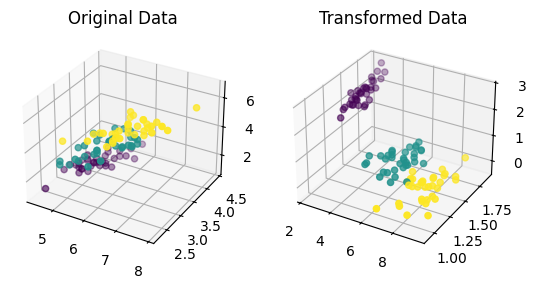

In [ ]:
#@title Draw a comparison plot of the test data before and after applying the learned transformation

plot_comparison(lmnn.components_, X_test, y_test, dim_pref=3)
plt.show()


In [ ]:


#@title Compare KNN and LMNN with olivetti_faces

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_olivetti_faces
np.random.seed(42)
RS=100

data = fetch_olivetti_faces()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RS)

knn = KNeighborsClassifier(n_neighbors=3)

# Train with no transformation (euclidean metric)
knn.fit(X_train, y_train)

# Test with euclidean metric
acc = knn.score(X_test, y_test)

print('KNN accuracy on test set: {}%'.format(acc))


# LMNN is no longer a classifier but a transformer
lmnn = LargeMarginNearestNeighbor(n_neighbors=3, verbose=1, random_state=RS)
lmnn.fit(X_train, y_train)

# Train with transformation learned by LMNN
knn.fit(lmnn.transform(X_train), y_train)

# Test with transformation learned by LMNN
acc = knn.score(lmnn.transform(X_test), y_test)

print('LMNN accuracy on test set: {}%'.format(acc))


KNN accuracy on test set: 0.8583333333333333%
[LargeMarginNearestNeighbor] Finding principal components...
[LargeMarginNearestNeighbor] Found principal components in  0.19s.
[LargeMarginNearestNeighbor] Finding the target neighbors...
[LargeMarginNearestNeighbor] Found the target neighbors in  0.12s.
[LargeMarginNearestNeighbor] Computing static part of the gradient...
[LargeMarginNearestNeighbor] Computed static part of the gradient in  0.32s.
[LargeMarginNearestNeighbor]
[LargeMarginNearestNeighbor]  Iteration      Objective Value     #Active Triplets    Time(s)
[LargeMarginNearestNeighbor] ---------------------------------------------------------------
[LargeMarginNearestNeighbor]          1         3.723153e+06                5,025       1.68
[LargeMarginNearestNeighbor]          1         7.114735e+05                2,901       1.68
[LargeMarginNearestNeighbor]          2         3.020689e+05                2,019       1.04
[LargeMarginNearestNeighbor]          3         1.979051e

/tmp/ipython-input-2949411666.py:293: ConvergenceWarning: [LargeMarginNearestNeighbor] LMNN did not converge: STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT
  warn('[{}] LMNN did not converge: {}'.format(
